In [1]:
import pims
import torch as tr
import random
import yaml
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

from vre.representations import build_representations_from_cfg
from vre.representations.extra.semantic_mapper import SemanticMapper
from vre.utils import get_project_root, collage_fn

%load_ext autoreload
%autoreload 2

In [2]:
"""setup all representations we want to use, including one representation per device"""
device = "cuda" if tr.cuda.is_available() else "cpu"
all_representations_dict = yaml.safe_load(f"""
rgb:
  type: default/rgb
  dependencies: []
  parameters: {{}}

mask2former_coco_47429163_0:
  type: semantic-segmentation/mask2former
  dependencies: []
  parameters:
    model_id: "47429163_0"
    semantic_argmax_only: True
  batch_size: 1
  device: {device}

mask2former_mapillary_49189528_0:
  type: semantic-segmentation/mask2former
  dependencies: []
  parameters:
    model_id: "49189528_0"
    semantic_argmax_only: True
  batch_size: 1
  device: {device}

depth_marigold:
  type: depth/marigold
  dependencies: []
  parameters:
    variant: marigold-lcm-v1-0
    denoising_steps: 4
    ensemble_size: 1
    processing_resolution: 768
  batch_size: 1
  device: {device}
""")

representations = build_representations_from_cfg(all_representations_dict)

[2024-10-17T12:56:53 VRE-DEBUG] Doing topological sort... (build_representations.py:build_representations_from_cfg:99)
[2024-10-17T12:56:53 VRE-INFO] Building 'depth/marigold' (vre name: depth_marigold) (build_representations.py:build_representation_from_cfg:77)
[2024-10-17T12:56:54 VRE-INFO] Explicit device provided: cuda. This device will be used at vre.run() (build_representations.py:build_representation_from_cfg:84)
[2024-10-17T12:56:54 VRE-INFO] Explicit batch size 1 provided to depth_marigold. (build_representations.py:build_representation_from_cfg:87)
[2024-10-17T12:56:54 VRE-INFO] Building 'semantic-segmentation/mask2former' (vre name: mask2former_mapillary_49189528_0) (build_representations.py:build_representation_from_cfg:77)
[2024-10-17T12:56:54 VRE-INFO] Explicit device provided: cuda. This device will be used at vre.run() (build_representations.py:build_representation_from_cfg:84)
[2024-10-17T12:56:54 VRE-INFO] Explicit batch size 1 provided to mask2former_mapillary_491895

In [3]:
mapillary_classes = ["Bird", "Ground Animal", "Curb", "Fence", "Guard Rail", "Barrier", "Wall", "Bike Lane",
                    "Crosswalk - Plain", "Curb Cut", "Parking", "Pedestrian Area", "Rail Track", "Road",
                    "Service Lane", "Sidewalk", "Bridge", "Building", "Tunnel", "Person", "Bicyclist",
                    "Motorcyclist", "Other Rider", "Lane Marking - Crosswalk", "Lane Marking - General",
                    "Mountain", "Sand", "Sky", "Snow", "Terrain", "Vegetation", "Water", "Banner", "Bench",
                    "Bike Rack", "Billboard", "Catch Basin", "CCTV Camera", "Fire Hydrant", "Junction Box",
                    "Mailbox", "Manhole", "Phone Booth", "Pothole", "Street Light", "Pole", "Traffic Sign Frame",
                    "Utility Pole", "Traffic Light", "Traffic Sign (Back)", "Traffic Sign (Front)", "Trash Can",
                    "Bicycle", "Boat", "Bus", "Car", "Caravan", "Motorcycle", "On Rails", "Other Vehicle", "Trailer",
                    "Truck", "Wheeled Slow", "Car Mount", "Ego Vehicle"]
coco_classes = ["person", "bicycle", "car", "motorcycle", "airplane", "bus", "train", "truck", "boat", "traffic light",
                "fire hydrant", "stop sign", "parking meter", "bench", "bird", "cat", "dog", "horse", "sheep", "cow",
                "elephant", "bear", "zebra", "giraffe", "backpack", "umbrella", "handbag", "tie", "suitcase", "frisbee",
                "skis", "snowboard", "sports ball", "kite", "baseball bat", "baseball glove", "skateboard", "surfboard",
                "tennis racket", "bottle", "wine glass", "cup", "fork", "knife", "spoon", "bowl", "banana", "apple",
                "sandwich", "orange", "broccoli", "carrot", "hot dog", "pizza", "donut", "cake", "chair", "couch",
                "potted plant", "bed", "dining table", "toilet", "tv", "laptop", "mouse", "remote", "keyboard",
                "cell phone", "microwave", "oven", "toaster", "sink", "refrigerator", "book", "clock", "vase",
                "scissors", "teddy bear", "hair drier", "toothbrush", "banner", "blanket", "bridge", "cardboard",
                "counter", "curtain", "door-stuff", "floor-wood", "flower", "fruit", "gravel", "house", "light",
                "mirror-stuff", "net", "pillow", "platform", "playingfield", "railroad", "river", "road", "roof",
                "sand", "sea", "shelf", "snow", "stairs", "tent", "towel", "wall-brick", "wall-stone", "wall-tile",
                "wall-wood", "water-other", "window-blind", "window-other", "tree-merged", "fence-merged",
                "ceiling-merged", "sky-other-merged", "cabinet-merged", "table-merged", "floor-other-merged",
                "pavement-merged", "mountain-merged", "grass-merged", "dirt-merged", "paper-merged",
                "food-other-merged", "building-other-merged", "rock-merged", "wall-other-merged", "rug-merged"]



In [4]:
mapillary_mapping = {
        "land": ["Terrain", "Sand", "Snow"],
        "forest": ["Vegetation"],
        "residential": ["Building", "Utility Pole", "Pole", "Fence", "Wall", "Manhole", "Street Light", "Curb",
                        "Guard Rail", "Caravan", "Junction Box", "Traffic Sign (Front)", "Billboard", "Banner",
                        "Mailbox", "Traffic Sign (Back)", "Bench", "Fire Hydrant", "Trash Can", "CCTV Camera",
                        "Traffic Light", "Barrier", "Rail Track", "Phone Booth", "Curb Cut", "Traffic Sign Frame",
                        "Bike Rack"],
        "road": ["Road", "Lane Marking - General", "Sidewalk", "Bridge", "Other Vehicle", "Motorcyclist", "Pothole",
                 "Catch Basin", "Car Mount", "Tunnel", "Parking", "Service Lane", "Lane Marking - Crosswalk",
                 "Pedestrian Area", "On Rails", "Bike Lane", "Crosswalk - Plain"],
        "little-objects": ["Car", "Person", "Truck", "Boat", "Wheeled Slow", "Trailer", "Ground Animal", "Bicycle",
                           "Motorcycle", "Bird", "Bus", "Ego Vehicle", "Bicyclist", "Other Rider"],
        "water": ["Water"],
        "sky": ["Sky"],
        "hill": ["Mountain"]
    }

color_map = [[0, 255, 0], [0, 127, 0], [255, 255, 0], [255, 255, 255],
             [255, 0, 0], [0, 0, 255], [0, 255, 255], [127, 127, 63]]
mapper = SemanticMapper(original_classes=[mapillary_classes], mapping=[mapillary_mapping],
                        color_map=color_map, name="paper_mapping",
                        dependencies=[representations["mask2former_mapillary_49189528_0"]])
representations[mapper.name] = mapper

In [5]:
mapping1 = {
    "man-made-construction": ["Building"],
    "others": [x for x in mapillary_classes if x != "Building"]
}
mapping2 = {
    "man-made-construction": ["building-other-merged", "house", "roof"],
    "others": [x for x in coco_classes if x not in ["building-other-merged", "house", "roof"]]
}
color_map = [[255, 255, 255], [0, 0, 0]]

def merge_fn(data):
    return ((data[0] + data[1]) != 0).astype(np.uint8) # both must be 'man-made-construction' as defined above

mapper2 = SemanticMapper(original_classes=[mapillary_classes, coco_classes], mapping=[mapping1, mapping2],
                         color_map=color_map, name="buildings_only",
                         dependencies=[representations["mask2former_mapillary_49189528_0"],
                                       representations["mask2former_coco_47429163_0"]],
                         merge_fn=merge_fn)
representations[mapper2.name] = mapper2

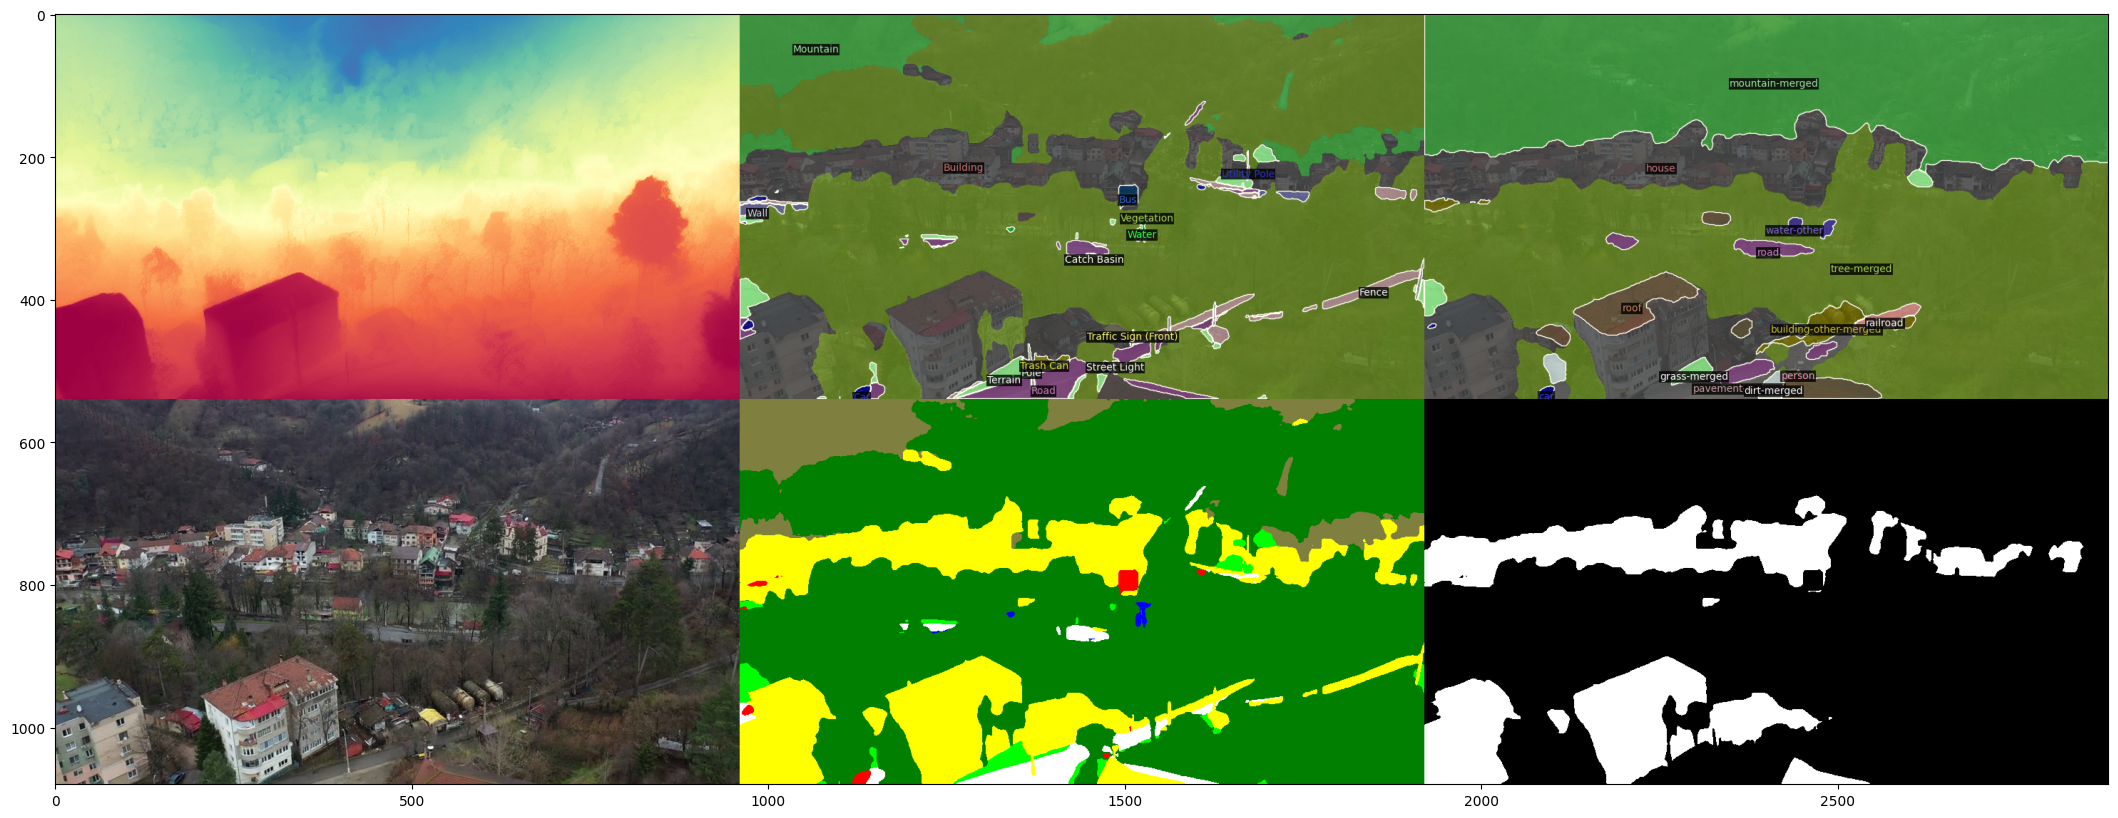

In [6]:
# video = pims.Video(get_project_root() / "resources/herculane_DJI_0021_full_540p.mp4")
imgs = []
ixs = sorted([int(x.stem) for x in (Path.cwd() / "data/rgb/npy").iterdir()])# if int(x.stem) <= len(video)])
_ixs = [random.choice(ixs)]
for k, r in representations.items():
    rgbs = np.array([np.load(Path.cwd() / f"data/rgb/npy/{ix}.npz")["arr_0"] for ix in _ixs])
    res = r.vre_make(video=None, ixs=_ixs, output_dir=Path.cwd() / "data")
    res_img = r.make_images(frames=rgbs, repr_data=res)[0]
    imgs.append(res_img)
plt.figure(figsize=(40, 10))
plt.imshow(collage_fn(imgs))
